In [37]:
# Import Libraries
from keras_facenet import FaceNet
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from datasets import Dataset, load_dataset, load_from_disk
import tensorflow as tf
from PIL import Image
import numpy as np

In [16]:
# Load Data
ds = load_from_disk("Final_Dataset")

# Train-Test Split
train_test = ds.train_test_split(test_size=0.2, seed=42)
train_val_ds = train_test["train"]
test_ds = train_test["test"]

# Train-Validation Split
train_val = train_val_ds.train_test_split(test_size=0.2, seed=42)
train_ds = train_val["train"]
val_ds = train_val["test"]

In [25]:
# Split into X and Y
target_size = (224, 224)

X_train = np.array([np.array(img.resize(target_size)) for img in train_ds["image"]])
Y_train = np.array(train_ds["labels"])

X_val = np.array([np.array(img.resize(target_size)) for img in val_ds["image"]])
Y_val = np.array(val_ds["labels"])

X_test = np.array([np.array(img.resize(target_size)) for img in test_ds["image"]])
Y_test = np.array(test_ds["labels"])


In [23]:
# Model Summary
embedder = FaceNet()
base_model = embedder.model
#model.summary()

In [8]:
# Add Binary Classification Layer
x = base_model.output
classification_output = Dense(1, activation='sigmoid', name='classification_layer')(x)
model = Model(inputs=base_model.input, outputs=classification_output)

In [9]:
# Freeze Base Model Layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile Last Layer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
# Fit the model
model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5360 - loss: 0.6926 - val_accuracy: 0.7594 - val_loss: 0.6720
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7871 - loss: 0.6647 - val_accuracy: 0.8500 - val_loss: 0.6472
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 974ms/step - accuracy: 0.8082 - loss: 0.6444 - val_accuracy: 0.8562 - val_loss: 0.6250
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8334 - loss: 0.6206 - val_accuracy: 0.8469 - val_loss: 0.6039
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8029 - loss: 0.6083 - val_accuracy: 0.8531 - val_loss: 0.5849


In [30]:
# Evaluate Model Before Fine-Tuning
print(f"Before fine-tuning, the model achieved an accuracy of: {model.evaluate(X_test, Y_test)[1] * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 785ms/step - accuracy: 0.7934 - loss: 0.6042
Before fine-tuning, the model achieved an accuracy of: 82.50%


In [31]:
# Unfreeze All Layers
for layer in model.layers:
    layer.trainable = True

In [32]:
# Re-Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
# Fine-Tune
model.fit(X_train, Y_train, epochs=3, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.9075 - loss: 0.4167 - val_accuracy: 0.9594 - val_loss: 0.4497
Epoch 2/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.9992 - loss: 0.1562 - val_accuracy: 0.9906 - val_loss: 0.2172
Epoch 3/3
40/40 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 1.0000 - loss: 0.1175 - val_accuracy: 1.0000 - val_loss: 0.1167


In [34]:
# Evaluate Model Before Fine-Tuning
print(f"After fine-tuning, the model achieved an accuracy of: {model.evaluate(X_test, Y_test)[1] * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 723ms/step - accuracy: 1.0000 - loss: 0.1170
After fine-tuning, the model achieved an accuracy of: 100.00%


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 821ms/step


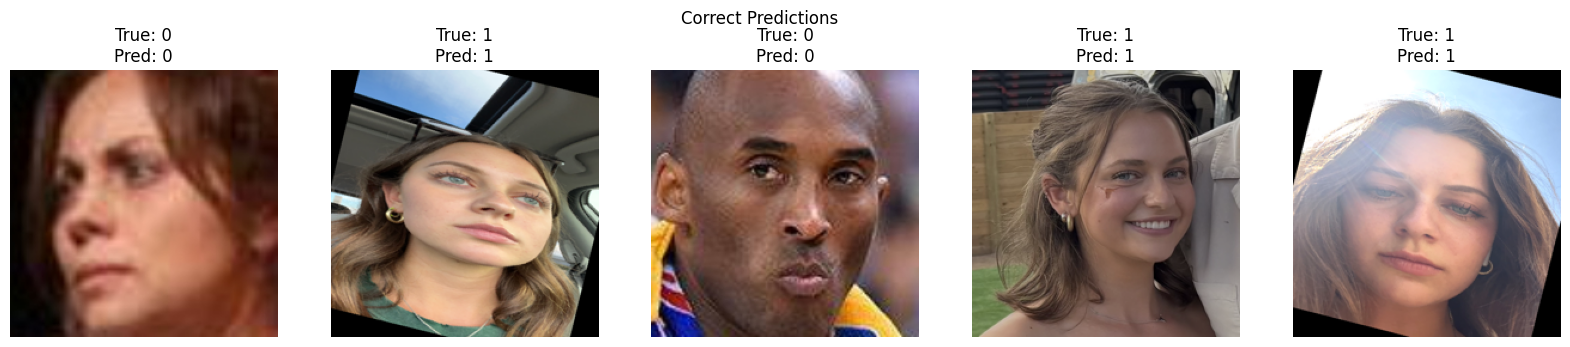

<Figure size 2000x400 with 0 Axes>

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Generate Predictions
predictions = model.predict(X_test)
pred_classes = (predictions > 0.5).astype(int).flatten()

# Find indices for correct and incorrect predictions
correct_indices = np.where(pred_classes == Y_test)[0]
wrong_indices = np.where(pred_classes != Y_test)[0]

# Plot Function
def plot_examples(indices, title, num_examples=5):
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(indices[:num_examples]):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(X_test[idx])
        plt.title(f"True: {Y_test[idx]}\nPred: {pred_classes[idx]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Correctly Classified Examples
plot_examples(correct_indices, "Correct Predictions")

# Incorrectly Classified Examples
plot_examples(wrong_indices, "Misclassified Predictions")


Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


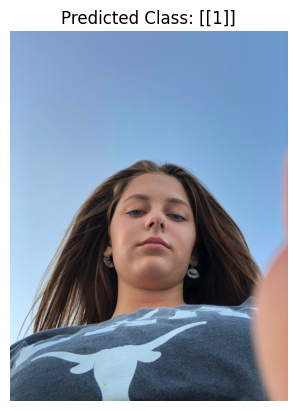

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


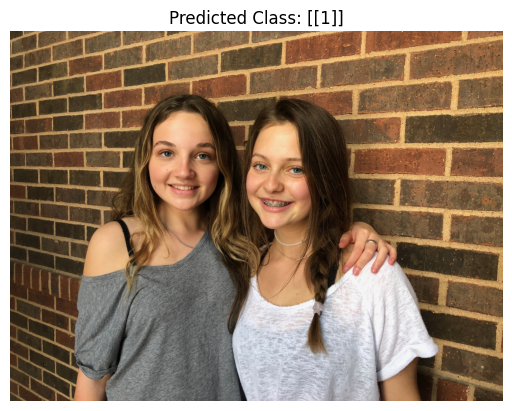

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


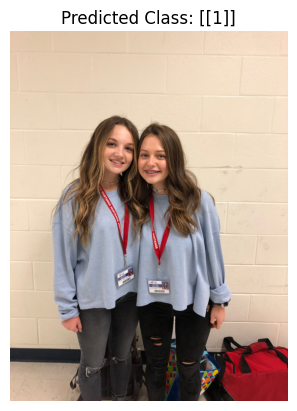

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


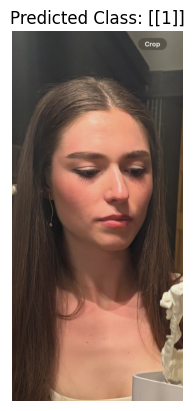

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


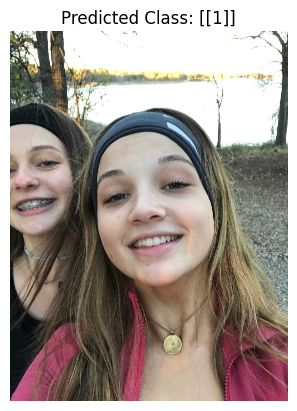

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


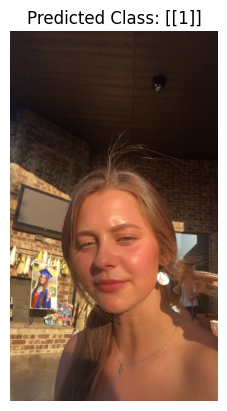

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


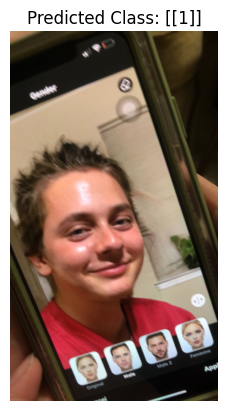

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


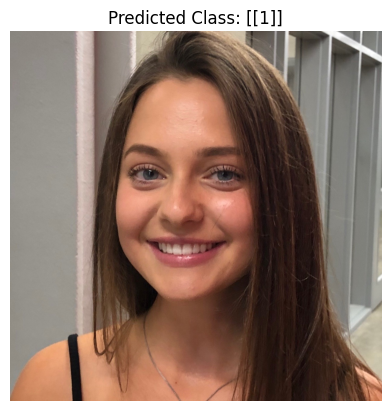

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


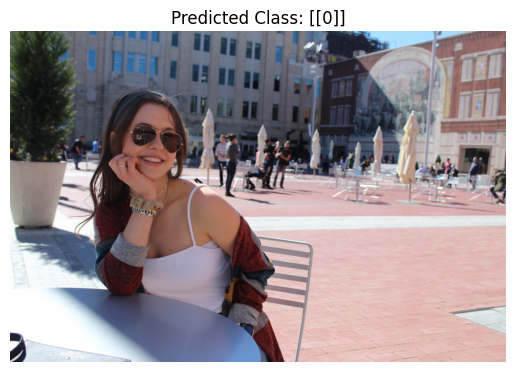

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


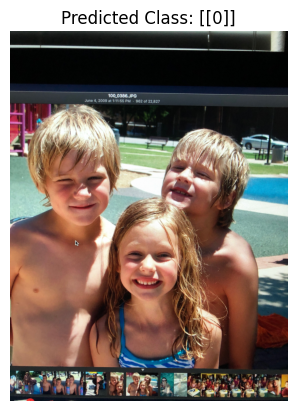

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


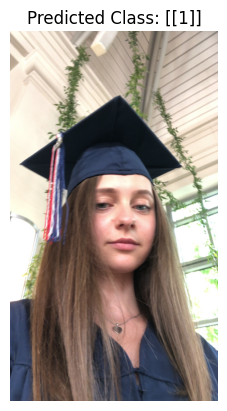

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


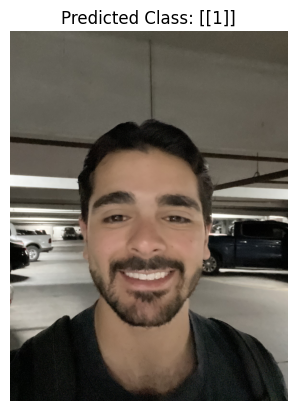

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


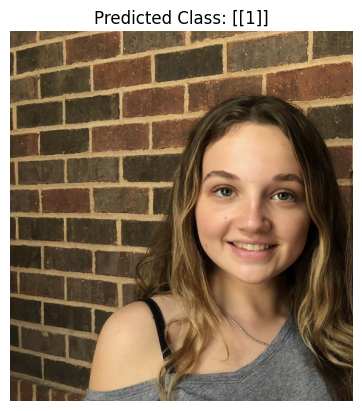

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


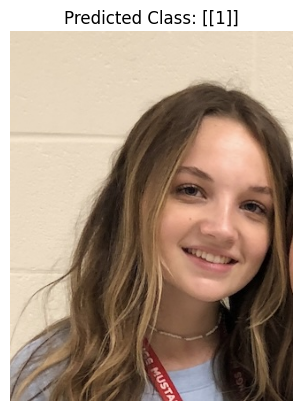

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


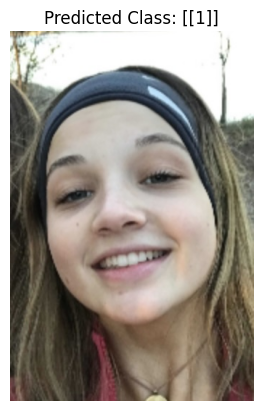

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


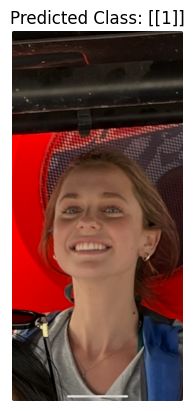

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


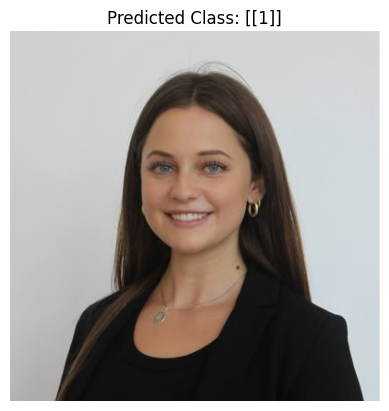

In [71]:
# Load in Positive Class
unseen_set = load_dataset("Jenna Test")

for i in range(len(unseen_set['train'])):
    img = unseen_set['train']['image'][i]
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = (prediction > 0.5).astype(int)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {predicted_class}")
    plt.show()